# Import necessary liberaries




In [1]:
!pip install tokenizers transformers -q

     |████████████████████████████████| 3.3MB 15.2MB/s 
     |████████████████████████████████| 2.1MB 37.0MB/s 
     |████████████████████████████████| 901kB 41.6MB/s 


In [2]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from tqdm.notebook import tqdm
tqdm.pandas()
from collections import Counter

from sklearn.model_selection import train_test_split
from skimage.io import imread_collection,imread

from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig
from tensorflow.keras.preprocessing.sequence import pad_sequences

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
save_path = "bert_base_uncased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)


# Preprocess Part 1
### Please Download the img firts.

1.   Normalize the text.
2.   Filter the text based on its length.
3.   Store the valid rows for resize the img.




In [4]:
# Download data from GCP
!gsutil cp gs://semloh_bucket1/memes_data.tsv ./
!gsutil cp gs://semloh_bucket1/meme_file_list.pkl ./

df = pd.read_csv('memes_data.tsv',sep='\t',usecols=['CaptionText','HashId','MemeLabel'])

Copying gs://semloh_bucket1/memes_data.tsv...
- [1 files][ 65.0 MiB/ 65.0 MiB]                                                
Operation completed over 1 objects/65.0 MiB.                                     
Copying gs://semloh_bucket1/meme_file_list.pkl...
/ [1 files][ 13.6 MiB/ 13.6 MiB]                                                
Operation completed over 1 objects/13.6 MiB.                                     


Normalize text


In [5]:
# Concatenate MemeLabel and Caption Text
df['CaptionText'] = df['MemeLabel'] + df['CaptionText']
# Remove punctuation
df["CaptionText"] = df["CaptionText"].progress_apply(lambda text: "".join([chr.lower() for chr in text if chr not in string.punctuation]))
# Remove Number
df["CaptionText"] = df["CaptionText"].progress_apply(lambda text: re.sub(r"\d+","",text))
# Remove large white space between the text
df["CaptionText"] = df["CaptionText"].progress_apply(lambda text: re.sub(r"(\s)\1{2,}","",text))
# Change word to id by WordPiece Tokenizer
df['CaptionText'] = df['CaptionText'].progress_apply(lambda x:tokenizer.encode(x).ids)

Filter image by caption length

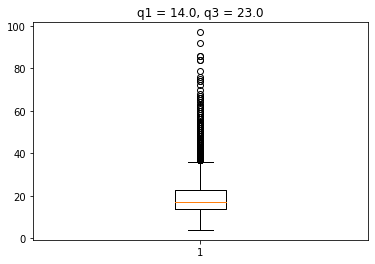

In [6]:
# Stroring length of sentence to filtering later
df['text_len'] = df['CaptionText'].progress_apply(lambda x:len(x))
# We want the text that no too short but not too long, such that we filtered only text with the length between q1 and q3. 
plt.boxplot(df['text_len'].values)
q1 = np.quantile(df['text_len'].values,.25)
q3 = np.quantile(df['text_len'].values,.75)
plt.title(f'q1 = {q1}, q3 = {q3}');
# Set min_seq as q1 and max_seq as q3
MIN_SEQ_LEN = int(q1)
MAX_SEQ_LEN = int(q3)

In [7]:
df_filtered_len = df.loc[(df['text_len']>=MIN_SEQ_LEN) & (df['text_len']<=MAX_SEQ_LEN)]

Filtered out the image that failed to download

In [8]:
img_file_list = pickle.load(open('meme_file_list.pkl','rb'))
df_filtered_len['HashId'] = df_filtered_len['HashId'].map(lambda x: x+'.png')
df_filtered_len = df_filtered_len.loc[df_filtered_len['HashId'].isin(img_file_list)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
# Pad the CaptionText to have the same length as MAX_SEQ
df_filtered_len['CaptionText'] = df_filtered_len['CaptionText'].progress_apply(lambda x:pad_sequences([x],maxlen=MAX_SEQ_LEN,padding='post').tolist()[0])
# Create the label in which it is shift-right version of the CaptionText.
df_filtered_len['label'] = df_filtered_len['CaptionText'].progress_apply(lambda x: x[1:] + [0])

Next, we want to down sample such that all the memes has the same number of samples

In [10]:
# Find the minimum number of meme 
min_meme_label = min(df_filtered_len['MemeLabel'].value_counts().values)

In [11]:
# Create DataFrame to store down sample version of the data
# Random_state = 42 for reproducable
df_down_sample = pd.DataFrame()
for group in df_filtered_len.groupby('MemeLabel'):
  memelabel = group[0]
  rows = group[1]
  df_down_sample = pd.concat([df_down_sample,rows.sample(n=int(min_meme_label),random_state=42)])

We split the data for train,val,test in 90,5,5 fashion

In [ ]:
df_train, x_, y_train, y_ = train_test_split(df_down_sample[['CaptionText','HashId','label']],
                                                    df_down_sample[['MemeLabel']],
                                                    stratify = df_down_sample[['MemeLabel']],
                                                    test_size=0.1, random_state=42)

In [ ]:
df_val, df_test, y_val, y_test = train_test_split(x_[['CaptionText','HashId','label']],
                                                y_[['MemeLabel']],
                                                stratify = y_[['MemeLabel']],
                                                test_size=0.5, random_state=42

In [ ]:
df_down_sample.to_parquet('file_list_for_resize.parquet.gzip',compression='gzip')

### Please run file 02_Resize.py to resize the img.

# Preprocess Part 2
### Please Resize the img first.

1.   Filter out the row in which the img is not resized.
2.   Create training and validation label.



In [ ]:
!gsutil cp gs://semloh_bucket1/resized_file_list.pkl ./

Copying gs://semloh_bucket1/resized_file_list.pkl...
/ [1 files][802.1 KiB/802.1 KiB]                                                
Operation completed over 1 objects/802.1 KiB.                                    


In [ ]:
# Filtered out picture that error during resize process
resized_file_list = pickle.load(open('resized_file_list.pkl','rb'))
df_train = df_train.loc[df_train['HashId'].isin(resized_file_list)]
df_val = df_val.loc[df_val['HashId'].isin(resized_file_list)]
df_test = df_test.loc[df_test['HashId'].isin(resized_file_list)]

In [ ]:
# Add path to HashId for loading image
RESIZED_IMG_BASE_PATH = './meme_for_train_resize/'
df_train['HashId'] = df_train['HashId'].apply(lambda x:RESIZED_IMG_BASE_PATH+x)
df_val['HashId'] = df_val['HashId'].apply(lambda x:RESIZED_IMG_BASE_PATH+x)
df_test['HashId'] = df_test['HashId'].apply(lambda x:RESIZED_IMG_BASE_PATH+x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Create label for training

In [ ]:
def create_label_for_train(data_point):
  global df_train_new
  HashId = data_point['HashId']
  CaptionText = data_point['CaptionText']
  tmp_hashId = [HashId] * (MAX_SEQ_LEN - 1)
  tmp_text_input = []
  tmp_label = []
  tmp_attention_mask = []
  for i in range(MAX_SEQ_LEN-1):
    tmp_text_input.append(CaptionText[:i+1])
    tmp_attention_mask.append([1 for _ in range(i+1)])
    tmp_label.append(CaptionText[i+1])
  tmp_text_input = pad_sequences(tmp_text_input,maxlen=MAX_SEQ_LEN,padding='post').tolist()
  tmp_attention_mask = pad_sequences(tmp_attention_mask,maxlen=MAX_SEQ_LEN,padding='post').tolist()
  tmp_df = pd.DataFrame({'HashId':tmp_hashId,
                         'CaptionText':tmp_text_input,
                         'attentionMask':tmp_attention_mask,
                         'label':tmp_label})
  df_train_new = pd.concat([df_train_new,tmp_df])

In [ ]:
def create_label_for_val(data_point):
  global df_val_new
  HashId = data_point['HashId']
  CaptionText = data_point['CaptionText']
  tmp_hashId = [HashId] * (MAX_SEQ_LEN - 1)
  tmp_text_input = []
  tmp_label = []
  tmp_attention_mask = []
  for i in range(MAX_SEQ_LEN-1):
    tmp_text_input.append(CaptionText[:i+1])
    tmp_attention_mask.append([1 for _ in range(i+1)])
    tmp_label.append(CaptionText[i+1])
  tmp_text_input = pad_sequences(tmp_text_input,maxlen=MAX_SEQ_LEN,padding='post').tolist()
  tmp_attention_mask = pad_sequences(tmp_attention_mask,maxlen=MAX_SEQ_LEN,padding='post').tolist()
  tmp_df = pd.DataFrame({'HashId':tmp_hashId,
                         'CaptionText':tmp_text_input,
                         'attentionMask':tmp_attention_mask,
                         'label':tmp_label})
  df_val_new = pd.concat([df_val_new,tmp_df])

In [ ]:
df_train_new = pd.DataFrame()
df_train.progress_apply(create_label_for_train,axis=1);

df_val_new = pd.DataFrame()
df_val.progress_apply(create_label_for_val,axis=1);

In [ ]:
# Remove the pad because the model learn nothing from generating pad
df_train_new = df_train_new.loc[df_train_new['label']!=0]
df_val_new = df_val_new.loc[df_val_new['label']!=0]

In [ ]:
# Shuffle Data and reset the index for datagenerator
df_train_new = df_train_new.sample(frac=1).reset_index(drop=True)
df_val_new = df_val_new.sample(frac=1).reset_index(drop=True)

In [ ]:
df_train_new.to_parquet('df_train.parquet.gzip',compression='gzip')
df_val_new.to_parquet('df_val.parquet.gzip',compression='gzip')
df_test.to_parquet('df_test.parquet.gzip',compression='gzip')